# **Data Mining Homework 4: Disaster Tweets Classification in PyTorch**

The task is about emergency awareness enhancement using tweets.

The dataset we are going to use is the [Disaster Tweets](https://www.kaggle.com/vstepanenko/disaster-tweets) from Kaggle which contains tweets collected from several disaster situations (volcanic eruption of Taal, coronavirus, etc).

So, given only the text of the tweet, we have to predicted whether it is a disaster-related tweet or not.

First, we will develop an LSTM neural network able to perform text classification in PyTorch. Then, we will do Transfer Learning using BERT comparing the results

# **Tweets Classification using LSTM**

Let's start developing our LSTM neural network

Torch should be already installed on Colab, but that may not be the case for TorchText

In [1]:
!pip install torchtext==0.6.0

Import the Torch libraries and mount Google Drive (it will ask for your personal token)

In [2]:
import torch
from torchtext import data

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set up a seed and ask the CUDA backend to perform deterministic computations to render out the experiment reproducible

In [3]:
import random

SEED = 31
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## **Data loading and processing**

Define functions to perform tweets preprocessing (tokenization and normalization)

In [4]:
import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords
from nltk.stem   import PorterStemmer

# Create a custom set of stop words by union multiple stop words languages and a custom set
'''stop_words = set(stopwords.words("english"))
stop_words = stop_words.union(stopwords.words("spanish"))
stop_words = stop_words.union(stopwords.words("italian"))
stop_words = stop_words.union(stopwords.words("french"))
stop_words = stop_words.union(stopwords.words("german"))'''

# Create a new instance of the PorterStemmer
stemmer = PorterStemmer()

# Tokenize tweets and preprocess them
def preprocessData(dataset):
  # Get the text of each tweet from input data 
  texts = dataset.split("\n")

  for text in texts:
    #print(text)
    return preprocessString(text)

def preprocessString(text):
  # Custom additional tokenizer, returns a list
  def __tokenize(token):
    separators = ["/", "+", ".", "…", ",", ";", ":", "-", "_", "`", "'", "\"", "#"]

    # Check if a separator is contained in the token
    for sep in separators:
      if sep in token:
        new_tokens = token.split(sep=sep, maxsplit=1)

        # Check if a float number has been splitted
        if (new_tokens[0].isdigit() and new_tokens[1].isdigit()):
          continue

        return __tokenize(new_tokens[0]) + __tokenize(new_tokens[1])

    return [token]


  if (text == ""):
    return []

  word_tokens = text.split(" ")
  filtered_tokens = []  

  #print("word_tokens: ", word_tokens)
  
  # Iterate tokens resulting from the first tokenizing step
  for t in word_tokens:
    # Ignore http/https links
    if t.startswith("http"):
      continue

    # Second tokenizing step (with lowercased characters)
    new_tokens = __tokenize(t.lower())
    #print("new_tokens: ", new_tokens)
  
    # Iterate tokens resulting from the second tokenizing step
    for nt in new_tokens:
      if len(nt)>1:
        filtered_tokens.append(nt)

      # Stopwords removal with stemming
      '''if nt not in stop_words and len(nt)>1:  
        #filtered_tokens.append(stemmer.stem(nt))
        filtered_tokens.append(nt)'''

  #print("filtered_tokens: ", filtered_tokens)
  return filtered_tokens

TorchText provides the **Field** and **LabelField** objects to specify how to treat the columns in the data that have to be considered as TEXT and LABEL, in our case.
The label consists in 1 if the tweet is a disaster-related one and 0 otherwise.

Load the data and use the custom preprocessing to tokenize the tweets

In [5]:
# Work with 'preprocessing' create a list of list in the "text" key
#TEXT  = data.Field(tokenize=lambda s: s.split("\n"), preprocessing=pre, batch_first=True, include_lengths=True)

# So, for avoiding list of list use 'tokenize' to tokenize and preprocess data
TEXT  = data.Field(tokenize=preprocessData, batch_first=True, include_lengths=True, fix_length=25)
LABEL = data.LabelField(dtype=torch.float, batch_first=True)

# Ignore the first 3 fields of the dataset and only use the tweet texts and the label denoting if the tweet is a disaster-related one or not
fields = [(None, None), (None, None), (None, None), ("text", TEXT), ("label", LABEL)]

FILENAME = "/content/drive/MyDrive/Colab Datasets/disaster_tweets_dataset.csv"

# Create a TabularDataset removing tweets which texts are constituting of only stop words
dataset = data.TabularDataset(path=FILENAME,
                              format="csv",
                              fields=fields,
                              skip_header=True,
                              filter_pred=lambda e: vars(e)["text"])

# Print dictionaries generated by tweets which texts are constituting of only stop words
'''for i in range(len(dataset)):
    dictionary = vars(dataset[i])
    if not dictionary["text"]:
      print(dictionary)'''

# Get the list of the entries in the dataset
entries = dataset.examples
dataset_size = len(entries)
print("Size of the dataset: ", dataset_size)

# Print the first three dictionaries generated
print("\nPrint the first three entries of the preprocessed dataset:")
for i in range(3):
  print(f"  {i}. ", vars(entries[i]))

Size of the dataset:  11367

Print the first three entries of the preprocessed dataset:
  0.  {'text': ['communal', 'violence', 'in', 'bhainsa', 'telangana', 'stones', 'were', 'pelted', 'on', 'muslims', 'houses', 'and', 'some', 'houses', 'and', 'vehicles', 'were', 'set', 'ablaze'], 'label': '1'}
  1.  {'text': ['telangana', 'section', '144', 'has', 'been', 'imposed', 'in', 'bhainsa', 'from', 'january', '13', 'to', '15', 'after', 'clash', 'erupted', 'between', 'two', 'groups', 'on', 'january', '12', 'po'], 'label': '1'}
  2.  {'text': ['arsonist', 'sets', 'cars', 'ablaze', 'at', 'dealership'], 'label': '1'}


Perform train/validation split

In [6]:
train_data, valid_data = dataset.split(split_ratio=0.7, random_state=random.seed(SEED))

print("Size of train data: ", len(train_data))
print("Size of validation data: ", len(valid_data))

Size of train data:  7957
Size of validation data:  3410


Build a vocabulary to be able to convert the texts into integer sequences to feed the neural net. \
In order to do that exploit two pretrained and very famous word embeddings: **fastText** and **GloVe** (Global Vectors for Word Representation). \
Out of vocabulary words are managed using an UNKNOWN token.

In [7]:
# Initialize fastText and GloVe embeddings
TEXT.build_vocab(train_data, min_freq=3, vectors=["fasttext.simple.300d", "glove.6B.300d"])
LABEL.build_vocab(train_data)

print("Some numbers about train data")

# Number of unique tokens in text
print("\nSize of TEXT vocabulary:", len(TEXT.vocab))

# Number of unique tokens in label
print("Size of LABEL vocabulary:", len(LABEL.vocab))

embedding_shape = TEXT.vocab.vectors.shape
print("\nShape of TEXT vocabulary vectors:", embedding_shape)
print("TEXT embedding dimension:", embedding_shape[1])

print("\nTop 10 most frequent words in TEXT vocabulary:", TEXT.vocab.freqs.most_common(10))  
print("Word dictionary:", TEXT.vocab.stoi)

print("\nLook at the distribution of the labels in LABEL vocabulary:", LABEL.vocab.freqs)  
print("Label dictionary:", LABEL.vocab.stoi)

Some numbers about train data

Size of TEXT vocabulary: 5302
Size of LABEL vocabulary: 2

Shape of TEXT vocabulary vectors: torch.Size([5302, 600])
TEXT embedding dimension: 600

Top 10 most frequent words in TEXT vocabulary: [('the', 5319), ('to', 3054), ('of', 2528), ('in', 2370), ('and', 2226), ('is', 1616), ('for', 1204), ('you', 1097), ('that', 1059), ('on', 1041)]
Word dictionary: defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f02e305b320>>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'to': 3, 'of': 4, 'in': 5, 'and': 6, 'is': 7, 'for': 8, 'you': 9, 'that': 10, 'on': 11, 'it': 12, 'this': 13, 'with': 14, 'are': 15, 'at': 16, 'have': 17, 'my': 18, 'was': 19, 'we': 20, 'be': 21, 'from': 22, 'by': 23, 'not': 24, 'an': 25, 'but': 26, 'they': 27, 'as': 28, 'all': 29, 'has': 30, 'just': 31, 'so': 32, 'will': 33, 'he': 34, '&amp': 35, 'if': 36, 'can': 37, 'people': 38, 'me': 39, 'who': 40, 'like': 41, 'when': 42, 'your': 43, 'about': 44, 'been': 45, 'ou

Since the dataset in unbalanced, calculate class weights with one method among the following ones:
* Proportion of samples labeled wrt the number of samples
* Proportion of samples labeled wrt class with the max number of samples
* Inverse of Number of Samples (INS)
* Inverse of Square Root of Number of Samples (ISNS)
* **Effective Number of Samples (ENS)**
* Inverse of distributions

In [8]:
#freqs = LABEL.vocab.freqs

freqs = {}
for i in range(dataset_size):
  d = vars(entries[i])
  label = d["label"]

  if label in freqs:
    freqs[label] += 1
  else:
    freqs[label] = 1

print("Look at the distribution of the labels in the dataset:", freqs)  


# Proportion of samples labeled wrt the number of samples
'''#n = train_data_size
n = dataset_size
print("Number of labels: ", n)

class_weights = {}
for key in freqs:
  freq = freqs[key]
  w = n/freq
  print("Weight for class " + key + ": ", w)
  class_weights[key] = w

#print("class_weights: ", class_weights)'''


# This method is a variation of the previous one but for more accurate weights taking into account the BATCH_SIZE
'''distributions = []

for freq in freqs.values():
  d = freq/n
  print("Distribution of class i: ", d)
  distributions.append(d)

BATCH_SIZE = 64

for distribution in distributions:
  samples_in_batch = BATCH_SIZE * distribution
  samples_in_batch_rounded = int(round(samples_in_batch))
  print("Samples for class i in a batch: ", samples_in_batch, " => ", samples_in_batch_rounded)
  print("Weight for class i in a batch: ", BATCH_SIZE/samples_in_batch_rounded)#'''


# Proportion of samples labeled wrt class with the max number of samples
'''max_freq = 0
for freq in freqs.values():
  if freq > max_freq:
    max_freq = freq

print("Max freq: ", max_freq)

class_weights = {}
for key in freqs:
  freq = freqs[key]
  w = max_freq/freq
  print("Weight for class " + key + ": ", w)
  class_weights[key] = w

#print("class_weights: ", class_weights)'''


# Inverse of Number of Samples (INS)
'''class_weights = {}
for key in freqs:
  freq = freqs[key]
  w = 1/freq * 1000
  print("Weight for class " + key + ": ", w)
  class_weights[key] = w

#print("class_weights: ", class_weights)#'''


# Inverse of Square Root of Number of Samples (ISNS)
'''import math  

class_weights = {}
for key in freqs:
  freq = freqs[key]
  w = 1/math.sqrt(freq) * 10
  print("Weight for class " + key + ": ", w)
  class_weights[key] = w

#print("class_weights: ", class_weights)#'''


# Effective Number of Samples (ENS)
#n = train_data_size
n = dataset_size
print("Number of labels: ", n)

class_weights = {}
for key in freqs:
  freq = freqs[key]
  beta = (n - 1) / n
  effective_num = (1 - pow(beta, freq)) / (1 - beta)
  w = 1/effective_num * 1000
  print("Weight for class " + key + ": ", w)
  class_weights[key] = w

#print("class_weights: ", class_weights)#'''


# Inverse of distributions
#n = train_data_size
#n = dataset_size
#print("Number of labels: ", n)

#for key in freqs:
#  freq = freqs[key]
#  d = freq/n
#  print("Distribution of class " + key + ": ", d)
#  w = 1 - d
#  print("Weight for class " + key + ": ", w)
#  class_weights[key] = w

#print("class_weights: ", class_weights)

Look at the distribution of the labels in the dataset: {'1': 2114, '0': 9253}
Number of labels:  11367
Weight for class 1:  0.5183657709228272
Weight for class 0:  0.15795838915926047


In order to prepare our data for proper loading, we use the **BucketIterator** class, which creates batches of input data such that we do not have to load the entire dataset at a time

In [9]:
# Check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

BATCH_SIZE = 64

# Load an iterator. We have to sort them by length since it will be needed for the padding
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

## **Model Architecture**
Once the data are prepared, we can proceed with the definition of our NN model.
In order to do that in PyTorch, we have to extend the Module class. Our network will be a LSTM (Long Short-Term Memory) Network.

LSTMs are a variant of RNNs that are able to learn long term dependencies in the input sequences, that are lost by standard RNNs that are suitable for short term relationships. The full neural network will be composed of the following components.



*   **Embedding layer**: this layer transforms the word into a vector (creating and embedding). It defines a look up table where each row is the embedding of  a word. It converts the sequence in input to a dense vector representation. We need to specify the number of unique words in the vocabulary and the length of the embedding. 
*   **LSTM layers**: layers implementing the LSTM functionalities. We have to specify several paramentes, see the code.
* **Linear layer**: fully connected layer, in which each node is connected to all the nodes of the previous layer.
* **Pack padding**: dealing with padded sequences can be tricky. This module tells the LSTM drop the state of the padded elements, which do not bring any useful info,
* **Dropout**: randomly switch off neurons (during training!) to prevent overfitting
 


In [10]:
import torch.nn as nn

class Classifier(nn.Module):  
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout,
                            bidirectional=bidirectional)
        
        # Fully connected layer
        self.fc  = nn.Linear(hidden_dim * 2, output_dim)
        # Activation function used for binary classification
        self.act = nn.Sigmoid()


        '''# Hidden layer
        self.h1    = nn.Linear(hidden_dim * 2, 512)
        self.act1  = nn.Sigmoid()
        self.drop1 = nn.Dropout(0.6)

        # Hidden layer
        self.h2    = nn.Linear(512, 256)
        self.act2  = nn.Sigmoid()
        self.drop2 = nn.Dropout(0.6) 

        # Hidden layer
        self.h3    = nn.Linear(256, 64)
        self.act3  = nn.Sigmoid()
        self.drop3 = nn.Dropout(0.6)
        
        # Hidden layer
        self.h4 = nn.Linear(64, output_dim)
        
        # Activation function used for binary classification
        self.act4 = nn.Sigmoid()'''
        
    def forward(self, text, text_lengths):
        # text shape is [batch size,sent length]
        embedded = self.embedding(text)
        # embedded shape is [batch size, sent length, embedding dim]
      
        # Packed padding sequence to pad the sequences for the LSTM.
        # We deal with sequences of different length that appear as having the same length due to the padding.
        # It is used not to consider the hidden states of the padded elements (which do not contain useful info)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden shape is [batch size, num layers * num directions, hidden dim]
        # cell shape is [batch size, num layers * num directions, hidden dim]
        
        # Concat the final forward and backward hidden state.
        # We are interested in the final hidden state, which contains the useful info
        # since we are in a bidirectional framework (in which we consider dependencies in both forward
        # and backwards direction in the sequence) we have to concatenate the states of both the directions
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        '''# hidden shape is [batch size, hidden dim * num directions]
        h1    = self.h1(hidden)
        act1  = self.act1(h1)
        drop1 = self.drop1(act1)

        h2    = self.h2(drop1)
        act2  = self.act2(h2)
        drop2 = self.drop2(act2)

        h3    = self.h3(drop2)
        act3  = self.act3(h3)
        drop3 = self.drop3(act3)
                
        h4 = self.h4(drop3)
        outputs = self.act4(h4)'''


        # hidden shape is [batch size, hidden dim * num directions]
        fc      = self.fc(hidden)
        outputs = self.act(fc)
        
        return outputs

Instantiate the model with the following hyperparameters

In [11]:
model = Classifier(vocab_size=embedding_shape[0],
                   embedding_dim=embedding_shape[1],
                   hidden_dim=256,
                   output_dim=1,
                   num_layers=7, #3, 
                   bidirectional=True,
                   dropout=0.7) #0.2)

Print some info about the model

In [12]:
# Architecture
print(model)

# Number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print("\nThe model has ", count_parameters(model) , " trainable parameters")

Classifier(
  (embedding): Embedding(5302, 600)
  (lstm): LSTM(600, 256, num_layers=7, batch_first=True, dropout=0.7, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (act): Sigmoid()
)

The model has  14400657  trainable parameters


Initialize the embedding layer with the pretrained embeddings from fastText and GloVe

In [13]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

torch.Size([5302, 600])


Define the optimizer and metrics for the model

In [14]:
import torch.optim as optim

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#criterion = nn.BCELoss()

# Define metric
def binary_accuracy(preds, y):
    # Round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# Move the model to GPU if available
model = model.to(device)
#criterion = criterion.to(device)

## **Training and Evaluation Phases**

Define a function to set class weights for the data in the batch

In [15]:
def set_class_weights(batch):
  #print(batch.label)
  weights = []

  for i in range(batch.batch_size):
    #print(batch.label[i])

    # Get the label from the tensor
    label = batch.label[i].item()
    #print(label)

    # Convert the label from a float into a string in order to access the class_weights dictionary
    label = str(int(label))
    #print(label)

    # Retrieve the weight associated to the label
    w = class_weights[label]
    #print(w)
    weights.append(w)

  return weights

Define *train* function

In [16]:
def train(model, iterator, optimizer, criterion):
    # Initialize every epoch 
    epoch_loss = 0
    epoch_acc  = 0
    
    # Set the model in training phase. Weights are updated and dropout layers activated
    model.train()
    
    for batch in iterator:
        # Reset the gradients after every batch
        optimizer.zero_grad()   
        
        # Retrieve text and number of words from the batch
        text, text_lengths = batch.text   
        
        # Make predictions and convert them to 1D tensor
        predictions = model(text, text_lengths.cpu()).squeeze()

        '''print("="*20)
        print("batch size: ", batch.batch_size)
        print("batch inputs: ", batch.input_fields)
        print("batch targets: ", batch.target_fields)
        print("predictions shape: ", predictions.shape)
        print("batch.label shape: ", batch.label.shape)

        #print("batch.text: ", batch.text)
        #print("batch.text[0]: ", batch.text[0])
        print("batch.text[0].shape: ", batch.text[0].shape)
        print("batch.text[1].shape: ", batch.text[1].shape)'''
        
        #print("batch.label: ", batch.label)#'''

        # Apply class weights to the batch if its size is equal to BATCH_SIZE (skip to apply weights to the last batch for tensors sizes issues) 
        '''criterion = None
        if batch.batch_size < BATCH_SIZE:
          criterion = nn.BCELoss()
        else:
          weights = set_class_weights(batch)
          weights = torch.tensor(weights)
          #print("weights.shape: ", weights.shape)
          criterion = nn.BCELoss(weight=weights)'''

        weights = set_class_weights(batch)
        weights = torch.tensor(weights)
        #print("weights.shape: ", weights.shape)
        criterion = nn.BCELoss(weight=weights)
        
        # Move the loss function to GPU if available
        criterion = criterion.to(device)
        
        # Compute loss and accuracy
        loss = criterion(predictions, batch.label)
        acc  = binary_accuracy(predictions, batch.label)   
        
        # Backpropagate the loss and compute the gradients
        loss.backward()       
        
        # Update the weights
        optimizer.step()      
        
        # Update epoch loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc  += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Define *evaluate* function

In [17]:
def evaluate(model, iterator, criterion):
    # Initialize every epoch
    epoch_loss = 0
    epoch_acc  = 0

    # Initialize the list of predicted and correct values every epoch
    predicted = []
    correct   = []

    # Set the model in evaluation phase. No weight update and dropout layers deactivated
    model.eval()
    
    # Deactivate autograd
    with torch.no_grad():
        for batch in iterator:
            # Retrieve text and number of words from the batch
            text, text_lengths = batch.text
            
            # Make predictions and convert them to 1D tensor
            predictions = model(text, text_lengths.cpu()).squeeze()

            # Apply class weights to the batch if its size is equal to BATCH_SIZE (skip to apply weights to the last batch for tensors sizes issues)
            '''criterion = None
            if batch.batch_size < BATCH_SIZE:
              criterion = nn.BCELoss()
            else:
              weights = set_class_weights(batch)
              weights = torch.tensor(weights)
              #print("weights.shape: ", weights.shape)
              criterion = nn.BCELoss(weight=weights)'''

            weights = set_class_weights(batch)
            weights = torch.tensor(weights)
            #print("weights.shape: ", weights.shape)
            criterion = nn.BCELoss(weight=weights)

            # Move the loss function to GPU if available 
            criterion = criterion.to(device)
            
            # Compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc  = binary_accuracy(predictions, batch.label)

            #print(predictions.shape)
            #print(batch.label.shape)

            # Add batch predictions and correct values to the lists storing all predictions and correct values
            for i in range(batch.batch_size):
              correct.append( round(batch.label[i].item()) )
              predicted.append( round(predictions[i].item()) )
            
            # Update epoch loss and accuracy
            epoch_loss += loss.item()
            epoch_acc  += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), correct, predicted

Train the model, save the best model weights and print some evaluation metrics (loss, accuracy, precision, recall and F1 score)

In [18]:
from sklearn.metrics import classification_report

EPOCHS = 20
best_valid_loss = float("inf")
best_acc        = 0
best_valid_correct   = []
best_valid_predicted = []

train_accuracies = []
valid_accuracies = []
train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    # Train the model
    #train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion=None)
    
    # Evaluate the model
    #valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    valid_loss, valid_acc, valid_correct, valid_predicted = evaluate(model, valid_iterator, criterion=None)

    # Update history
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Save the best model 
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), "saved_weights.pt")

    if valid_acc > best_acc:
      best_acc = valid_acc
      best_valid_correct   = valid_correct
      best_valid_predicted = valid_predicted
    
    print(f"{epoch}.\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"{epoch}.\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

lstm_accuracy = best_acc
lstm_loss     = best_valid_loss

print("\n", classification_report(best_valid_correct, best_valid_predicted))

0.	Train Loss: 0.131 | Train Acc: 78.71%
0.	 Val. Loss: 0.104 |  Val. Acc: 80.54%
1.	Train Loss: 0.092 | Train Acc: 85.09%
1.	 Val. Loss: 0.099 |  Val. Acc: 86.31%
2.	Train Loss: 0.084 | Train Acc: 86.46%
2.	 Val. Loss: 0.104 |  Val. Acc: 82.23%
3.	Train Loss: 0.073 | Train Acc: 88.65%
3.	 Val. Loss: 0.097 |  Val. Acc: 85.59%
4.	Train Loss: 0.066 | Train Acc: 89.75%
4.	 Val. Loss: 0.099 |  Val. Acc: 85.44%
5.	Train Loss: 0.056 | Train Acc: 91.27%
5.	 Val. Loss: 0.096 |  Val. Acc: 85.33%
6.	Train Loss: 0.046 | Train Acc: 93.57%
6.	 Val. Loss: 0.108 |  Val. Acc: 85.57%
7.	Train Loss: 0.041 | Train Acc: 94.23%
7.	 Val. Loss: 0.113 |  Val. Acc: 87.96%
8.	Train Loss: 0.033 | Train Acc: 95.69%
8.	 Val. Loss: 0.121 |  Val. Acc: 84.54%
9.	Train Loss: 0.032 | Train Acc: 95.67%
9.	 Val. Loss: 0.117 |  Val. Acc: 82.44%
10.	Train Loss: 0.026 | Train Acc: 96.69%
10.	 Val. Loss: 0.164 |  Val. Acc: 87.76%
11.	Train Loss: 0.022 | Train Acc: 97.61%
11.	 Val. Loss: 0.151 |  Val. Acc: 85.09%
12.	Train Lo

Plot the history of the accuracy

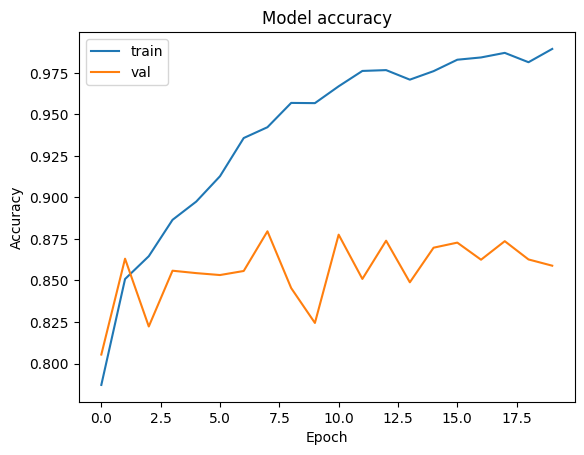

In [19]:
import matplotlib.pyplot as plt
plt.style.use('default')

plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc="upper left")
plt.savefig("/content/drive/MyDrive/LSTM accuracy history.pdf")
plt.show()

Plot the history of the loss

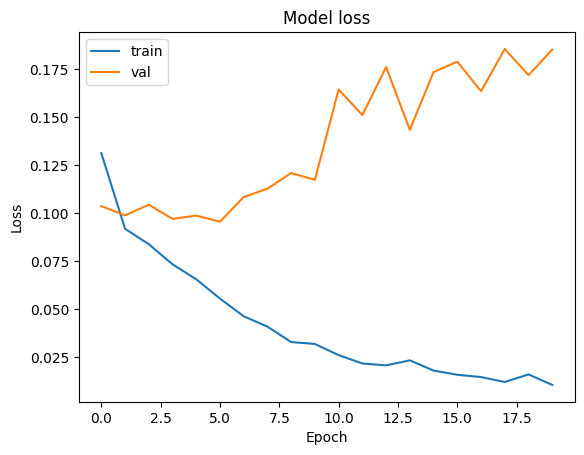

In [20]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc="upper left")
plt.savefig("/content/drive/MyDrive/LSTM loss history.pdf")
plt.show()

Plot the confusion matrix

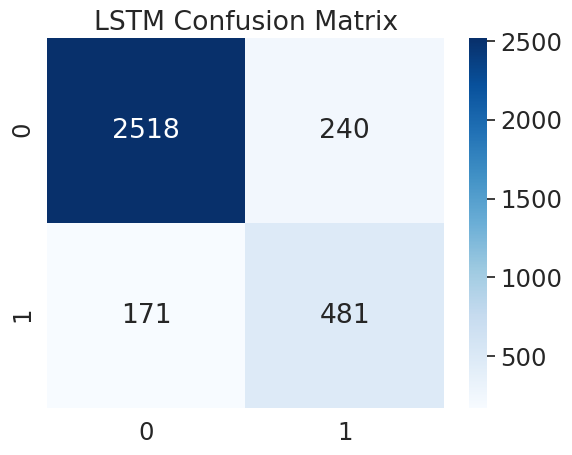

In [21]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

sn.set(font_scale=1.6)

target_names = [l for l in LABEL.vocab.stoi]

cm = confusion_matrix(best_valid_correct, best_valid_predicted)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

plt.title("LSTM Confusion Matrix")
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt="g")
plt.savefig("/content/drive/MyDrive/LSTM Confusion Matrix.pdf")
plt.show()

# **Transfer Learning using BERT**

The developing of our LSTM neural net is over, now let's start implementing Transfer Learning using BERT.

NB: We will repeat some code used above in order to offer the possibility to run the two models independently

Install the Transformers library that contains PyTorch, Tensorflow and Flax implementations of an impressive number of Transfer Learning models

In [22]:
!pip install transformers==3.5

Import the Torch libraries and mount Google Drive (it will ask for your personal token)

In [23]:
import torch

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set up a seed and ask the CUDA backend to perform deterministic computations to render out the experiment reproducible

In [24]:
import random

SEED = 31
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Check if a GPU is available (must have to finetune BERT)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Initializing the model**

Google has made available a range of BERT models for us to experiment with.

Since in this homework we're going to investigate tweets (from different countries) for predicting if a tweet is a disaster-related tweet or not and the *bert-base-multilingual-uncased* is not recommended (see [here](https://huggingface.co/transformers/pretrained_models.html)), we'll therefore use the *bert-base-multilingual-cased* model.

In [26]:
#BERT_MODEL = "bert-base-uncased"
#BERT_MODEL = "bert-large-uncased"
BERT_MODEL = "bert-base-multilingual-cased"

Each model comes with its own tokenizer. This tokenizer splits texts into word pieces. \
Download the vocabulary employed during pretraining or fine-tuning a given model

In [27]:
from transformers.tokenization_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

Instantiate the pretrained BERT model with a final layer for sequence classification on top since the homework task is to classify tweets

In [28]:
from transformers.modeling_bert import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(BERT_MODEL)
model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

## **Data loading and processing**

Load the disaster tweets dataset dropping the rows with a null value in the *text* or *target* field

In [29]:
import pandas as pd
import numpy  as np

FILENAME = "/content/drive/MyDrive/Colab Datasets/disaster_tweets_dataset.csv"
dataset = pd.read_csv(FILENAME, usecols=["text", "target"])

#dataset.info()

# Replace empty strings with null values and then drop such rows
dataset["text"].replace('', np.nan, inplace=True)
dataset["target"].replace('', np.nan, inplace=True)
dataset.dropna(inplace=True)

#dataset.info()

texts  = dataset["text"]
labels = dataset["target"]

Perform train/test split

In [30]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, train_size=0.7, random_state=random.seed(SEED))

train_data_size = len(train_texts)
test_data_size  = len(test_texts)
dataset_size    = train_data_size + test_data_size

print("Size of the dataset: ", dataset_size)
print("Size of train data: ", train_data_size)
print("Size of validation data: ", test_data_size)

Size of the dataset:  11370
Size of train data:  7958
Size of validation data:  3412


Determine the number of labels in our data and map each label to an index (necessary only if we have strings but we put it to keep the code more general as possible in order to give the possibility to reuse it)

In [31]:
target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{0: 0, 1: 1}


Prepare data for BERT by presenting every document as a **BertInputItem** object, which contains all the information BERT needs:

* a list of input IDs: Every text has been split up into subword units, which are shared between all the languages in the multilingual model.
  When a word appears frequently enough in a combined corpus of all languages, it is kept intact. If it is less frequent, it is split up into subword units that do occur frequently enough across all languages. This allows our model to process every text as a sequence of strings from a finite vocabulary of limited size. \
  The [CLS] token is added at the beginning of every document. The vector at the output of this token will be used by the BERT model for its sequence classification tasks: it serves as the input of the final, task-specific part of the neural network.

* the input mask: the input mask tells the model which parts of the input it should look at and which parts it should ignore. \
  Since I made texts of a fixed length of tokens, some tweets may be cut off after this limit while other may be padded with extra tokens.
  In this latter case, these padding tokens will receive a mask value of 0, which means BERT should not take them into account for its classification task.

* the segment IDs: some NLP task take several sequences as input and the segment IDs tell BERT which sequence every token belongs to.
  However, in a text classification task, there's only one segment, so all the input tokens receive segment ID = 0.

* the label ID: the ID of the label of the document.

In [32]:
MAX_SEQ_LENGTH = 100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT"""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text        = text
        self.input_ids   = input_ids
        self.input_mask  = input_mask
        self.segment_ids = segment_ids
        self.label_id    = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of InputBatch"""
    
    input_items = []
    examples = zip(example_texts, example_labels)

    for (ex_index, (text, label)) in enumerate(examples):
        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")

        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0)
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids   += padding
        input_mask  += padding
        segment_ids += padding

        assert len(input_ids)   == max_seq_length
        assert len(input_mask)  == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append( BertInputItem(text=text,
                                          input_ids=input_ids,
                                          input_mask=input_mask,
                                          segment_ids=segment_ids,
                                          label_id=label_id) )
         
    return input_items


train_features = convert_examples_to_inputs(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features  = convert_examples_to_inputs(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)

Is the dataset unbalanced?

In [33]:
freqs = {}
for label in labels:
  if label in freqs:
    freqs[label] += 1
  else:
    freqs[label] = 1

print(freqs)

{1: 2114, 0: 9256}


Yes it is, therefore calculate weights with one method among the following ones:
* Proportion of samples labeled wrt the number of samples
* Proportion of samples labeled wrt class with the max number of samples
* Inverse of Number of Samples (INS)
* Inverse of Square Root of Number of Samples (ISNS)
* **Effective Number of Samples (ENS)**
* Inverse of distributions

In [34]:
# Proportion of samples labeled wrt the number of samples
'''#n = train_data_size
n = dataset_size
print("Number of labels: ", n)

class_weights = {}
for key in freqs:
  freq = freqs[key]
  w = n/freq
  print("Weight for class " + str(key) + ": ", w)
  class_weights[key] = w

àprint("class_weights: ", class_weights)'''


# This method is a variation of the previous one but for more accurate weights taking into account the BATCH_SIZE
'''distributions = []

for freq in freqs.values():
  d = freq/n
  print("Distribution of class i: ", d)
  distributions.append(d)

BATCH_SIZE = 16

for distribution in distributions:
  samples_in_batch = BATCH_SIZE * distribution
  samples_in_batch_rounded = int(round(samples_in_batch))
  print("Samples for class i in a batch: ", samples_in_batch, " => ", samples_in_batch_rounded)
  print("Weight for class i in a batch: ", BATCH_SIZE/samples_in_batch_rounded)#'''


# Proportion of samples labeled wrt class with the max number of samples
'''max_freq = 0
for freq in freqs.values():
  if freq > max_freq:
    max_freq = freq

print("Max freq: ", max_freq)

class_weights = {}
for key in freqs:
  freq = freqs[key]
  w = max_freq/freq
  print("Weight for class " + str(key) + ": ", w)
  class_weights[key] = w

#print("class_weights: ", class_weights)'''


# Inverse of Number of Samples (INS)
'''class_weights = {}
for key in freqs:
  freq = freqs[key]
  w = 1/freq * 1000
  print("Weight for class " + str(key) + ": ", w)
  class_weights[key] = w

#print("class_weights: ", class_weights)#'''


# Inverse of Square Root of Number of Samples (ISNS)
'''import math  

class_weights = {}
for key in freqs:
  freq = freqs[key]
  w = 1/math.sqrt(freq) * 10
  print("Weight for class " + str(key) + ": ", w)
  class_weights[key] = w

#print("class_weights: ", class_weights)#'''


# Effective Number of Samples (ENS)
#n = train_data_size
n = dataset_size
print("Number of labels: ", n)

class_weights = {}
for key in freqs:
  freq = freqs[key]
  beta = (n - 1) / n
  effective_num = (1 - pow(beta, freq)) / (1 - beta)
  w = 1/effective_num * 1000
  print("Weight for class " + str(key) + ": ", w)
  class_weights[key] = w

#print("class_weights: ", class_weights)#


# Inverse of distributions
#n = train_data_size
#n = dataset_size
#print("Number of labels: ", n)

#for key in freqs:
#  freq = freqs[key]
#  d = freq/n
#  print("Distribution of class " + str(key) + ": ", d)
#  w = 1 - d
#  print("Weight for class " + str(key) + ": ", w)
#  class_weights[key] = w

#print("class_weights: ", class_weights)

Number of labels:  11370
Weight for class 1:  0.5183534517388022
Weight for class 0:  0.15791054832809015


Initialize a data loader for training and testing data making use of the **WeightedRandomSampler** to rebalance the dataset. \
This data loader puts all our data in tensors and will allow us to iterate over them during training

In [35]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

def get_data_loader(features, features_size, weights, max_seq_length, batch_size): 
    all_input_ids   = torch.tensor([f.input_ids   for f in features], dtype=torch.long)
    all_input_mask  = torch.tensor([f.input_mask  for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids   = torch.tensor([f.label_id    for f in features], dtype=torch.long)

    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    sampler = WeightedRandomSampler(weights, features_size)

    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

# Build weights arrays assigning to each input its own class weight
train_weights = [class_weights[x.label_id] for x in train_features]
test_weights  = [class_weights[y.label_id] for y in test_features]

train_dataloader = get_data_loader(train_features, train_data_size, train_weights, MAX_SEQ_LENGTH, BATCH_SIZE)
test_dataloader  = get_data_loader(test_features, test_data_size, test_weights, MAX_SEQ_LENGTH, BATCH_SIZE)

## **Training and Evaluation phases**

Define metrics



In [36]:
def binary_accuracy(preds, y):
  return np.mean(preds == y)

Define *evaluate* function

In [37]:
def evaluate(model, dataloader):
    # Initialize every epoch
    epoch_loss = 0
    epoch_acc  = 0

    # Initialize the list of predicted and correct values every epoch
    predicted_labels = []
    correct_labels   = []

    # Set the model in evaluation phase. No weight update and dropout layers deactivated
    model.eval()

    steps = 0
    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
          # Compute loss
          loss, logits = model(input_ids,
                               attention_mask=input_mask,
                               token_type_ids=segment_ids,
                               labels=label_ids) 

        # Get batch predictions and correct values
        preds    = np.argmax(logits.to('cpu'), axis=1)
        corrects = label_ids.to('cpu').numpy()

        # Convert the predictions tensor in a list
        predictions = []
        for i in range(len(preds)):
          #print(batch.label[i])

          # Get the predicted label from the tensor
          label = preds[i].item()
          #print(label)

          predictions.append(label)

        '''print("preds:", preds)
        print("predictions:", predictions)
        print("corrects:", corrects)'''

        # Compute accuracy
        acc  = binary_accuracy(predictions, corrects) 
        
        # Add batch predictions and correct values to the lists storing all predictions and correct values
        predicted_labels += list(preds)
        correct_labels   += list(corrects)
        
        # Update epoch loss and accuracy
        epoch_loss += loss.item()
        epoch_acc  += acc.item()

        steps += 1

    
    correct_labels   = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return epoch_loss / steps, epoch_acc / steps, correct_labels, predicted_labels

Define the optimizer and the training hyperparameters for the model

In [38]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS            = 15
LEARNING_RATE               = 0.0000005
WARMUP_PROPORTION           = 0.1
MAX_GRAD_NORM               = 5

num_train_steps  = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = model.named_parameters()
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0} ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)#, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

Train the model and save the best model weights

In [39]:
import os

from tqdm import trange
from tqdm.notebook import tqdm

from sklearn.metrics import classification_report#, precision_recall_fscore_support

OUTPUT_DIR      = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE        = 5

train_accuracies = []
test_accuracies  = []
train_losses = []
test_losses  = []

no_improvement = 0

for epoch in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
    
    # Evaluate the model
    train_loss, train_acc, _, _ = evaluate(model, train_dataloader)
    test_loss, test_acc, _, _   = evaluate(model, test_dataloader)

    print(f"{epoch}.\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"{epoch}.\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%")

    if len(test_losses) == 0 or test_loss < min(test_losses):
        no_improvement = 0

        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1
    
    if no_improvement >= PATIENCE: 
        print("No improvement on test set. Finish training.")
        break 
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]


0.	Train Loss: 0.617 | Train Acc: 68.98%
0.	 Val. Loss: 0.616 |  Val. Acc: 69.13%


Epoch:   7%|▋         | 1/15 [04:02<56:32, 242.31s/it]


1.	Train Loss: 0.438 | Train Acc: 80.88%
1.	 Val. Loss: 0.454 |  Val. Acc: 78.83%


Epoch:  13%|█▎        | 2/15 [08:05<52:32, 242.53s/it]


2.	Train Loss: 0.394 | Train Acc: 82.84%
2.	 Val. Loss: 0.398 |  Val. Acc: 82.89%


Epoch:  20%|██        | 3/15 [12:08<48:34, 242.83s/it]

Epoch:  27%|██▋       | 4/15 [16:08<44:21, 241.95s/it]


3.	Train Loss: 0.363 | Train Acc: 84.92%
3.	 Val. Loss: 0.413 |  Val. Acc: 82.33%



4.	Train Loss: 0.339 | Train Acc: 86.07%
4.	 Val. Loss: 0.392 |  Val. Acc: 83.41%


Epoch:  33%|███▎      | 5/15 [20:12<40:24, 242.43s/it]


5.	Train Loss: 0.321 | Train Acc: 87.08%
5.	 Val. Loss: 0.367 |  Val. Acc: 84.11%


Epoch:  40%|████      | 6/15 [24:15<36:23, 242.58s/it]


6.	Train Loss: 0.313 | Train Acc: 87.10%
6.	 Val. Loss: 0.358 |  Val. Acc: 84.84%


Epoch:  47%|████▋     | 7/15 [28:19<32:25, 243.18s/it]


7.	Train Loss: 0.302 | Train Acc: 87.40%
7.	 Val. Loss: 0.357 |  Val. Acc: 85.37%


Epoch:  53%|█████▎    | 8/15 [32:24<28:25, 243.71s/it]

Epoch:  60%|██████    | 9/15 [36:25<24:17, 242.92s/it]


8.	Train Loss: 0.302 | Train Acc: 87.83%
8.	 Val. Loss: 0.367 |  Val. Acc: 85.22%



9.	Train Loss: 0.284 | Train Acc: 88.33%
9.	 Val. Loss: 0.348 |  Val. Acc: 85.43%


Epoch:  67%|██████▋   | 10/15 [40:29<20:15, 243.09s/it]


10.	Train Loss: 0.285 | Train Acc: 88.96%
10.	 Val. Loss: 0.348 |  Val. Acc: 86.10%


Epoch:  73%|███████▎  | 11/15 [44:33<16:13, 243.32s/it]

Epoch:  80%|████████  | 12/15 [48:33<12:07, 242.49s/it]


11.	Train Loss: 0.266 | Train Acc: 89.34%
11.	 Val. Loss: 0.352 |  Val. Acc: 85.37%



12.	Train Loss: 0.264 | Train Acc: 89.40%
12.	 Val. Loss: 0.340 |  Val. Acc: 85.72%


Epoch:  87%|████████▋ | 13/15 [52:37<08:05, 242.89s/it]

Epoch:  93%|█████████▎| 14/15 [56:37<04:02, 242.14s/it]


13.	Train Loss: 0.267 | Train Acc: 89.37%
13.	 Val. Loss: 0.342 |  Val. Acc: 86.19%


Epoch: 100%|██████████| 15/15 [1:00:38<00:00, 242.55s/it]


14.	Train Loss: 0.265 | Train Acc: 89.43%
14.	 Val. Loss: 0.358 |  Val. Acc: 85.13%


Load the best model and print some evaluation metrics (loss, accuracy, precision, recall and F1 score)

In [40]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model.to(device)

model.eval()

_, _, train_correct, train_predicted                = evaluate(model, train_dataloader)
test_loss, test_acc, test_correct, test_predicted   = evaluate(model, test_dataloader)

#print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
#print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = test_acc
bert_loss = test_loss

print(classification_report(test_correct, test_predicted))


              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1974
           1       0.82      0.83      0.82      1438

    accuracy                           0.85      3412
   macro avg       0.85      0.85      0.85      3412
weighted avg       0.85      0.85      0.85      3412



Plot the history of the accuracy

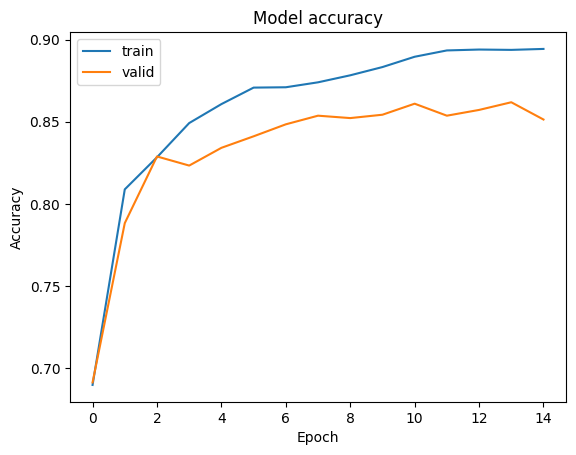

In [41]:
import matplotlib.pyplot as plt
plt.style.use('default')

plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper left")
plt.savefig("/content/drive/MyDrive/BERT accuracy history.pdf")
plt.show()

Plot the history of the loss

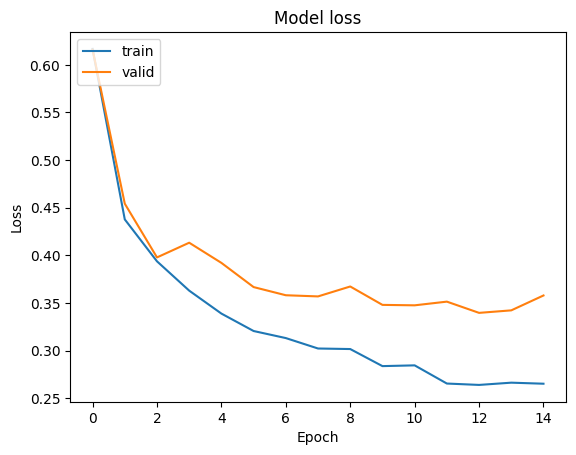

In [42]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper left")
plt.savefig("/content/drive/MyDrive/BERT loss history.pdf")
plt.show()

Plot the confusion matrix

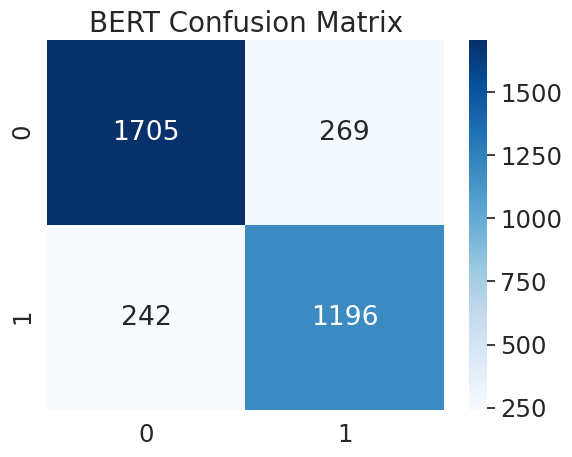

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

sn.set(font_scale=1.6)

cm = confusion_matrix(test_correct, test_predicted)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

plt.title("BERT Confusion Matrix", fontsize=20)
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt="g")
plt.savefig("/content/drive/MyDrive/BERT Confusion Matrix.pdf")
plt.show()

# **Comparison of the results**

Compare the accuracies of the models

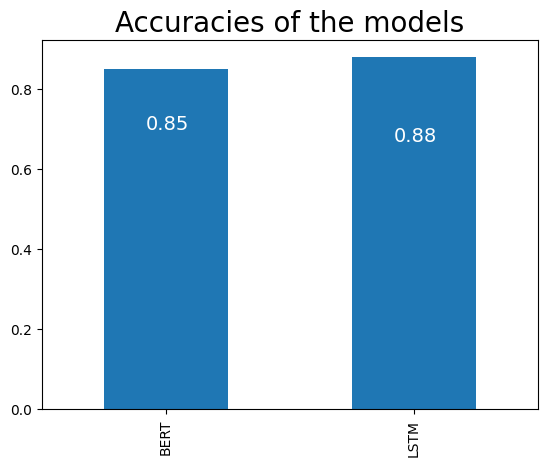

In [47]:
# Create a dataframe with the accuracies of the models
df = pd.DataFrame({"accuracy": {"LSTM": lstm_accuracy, "BERT": bert_accuracy}})

# Show a bar plot of them
plt.style.use('default')
df.plot(kind="bar", legend=None)

plt.title("Accuracies of the models", fontsize=20)
plt.text(-0.08, 0.7, f"{bert_accuracy:.2f}", color="white", fontsize=14)
plt.text(0.92, 0.67, f"{lstm_accuracy:.2f}", color="white", fontsize=14)
plt.savefig("/content/drive/MyDrive/Models accuracies.pdf")
plt.show()

Compare the losses of the models

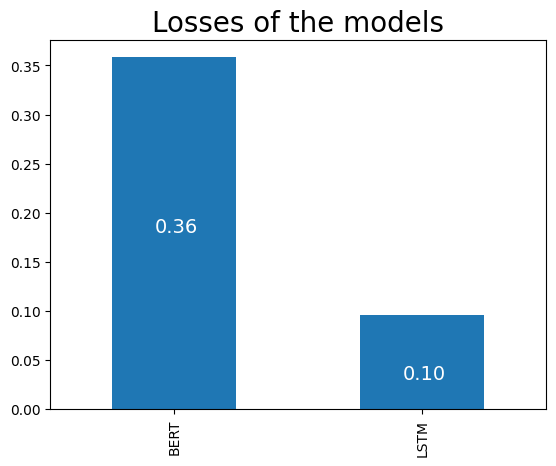

In [45]:
# Create a dataframe with the accuracies of the models
df = pd.DataFrame({"loss": {"LSTM": lstm_loss, "BERT": bert_loss}})

# Show a bar plot of them
plt.style.use('default')
df.plot(kind="bar", legend=None)

plt.title("Losses of the models", fontsize=20)
plt.text(-0.08, 0.18, f"{bert_loss:.2f}", color="white", fontsize=14)
plt.text(0.92, 0.03, f"{lstm_loss:.2f}", color="white", fontsize=14)
plt.savefig("/content/drive/MyDrive/Models losses.pdf")
plt.show()

Compare the confusion matrices of the models

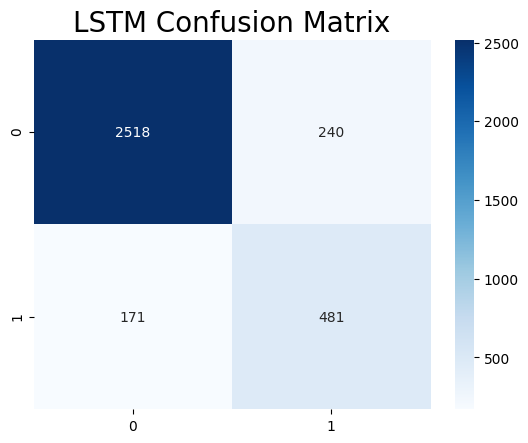

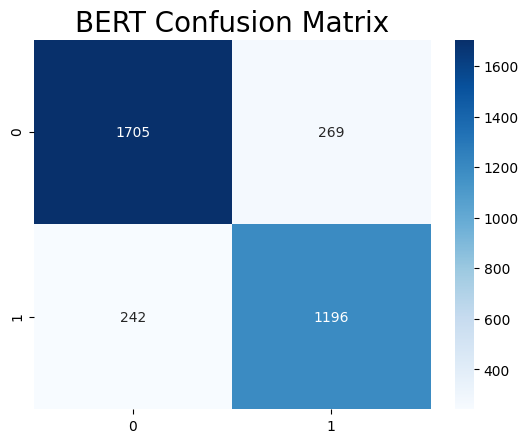

In [46]:
# Compute LSTM confusion matrix
cm = confusion_matrix(best_valid_correct, best_valid_predicted)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

# Show LSTM confusion matrix
plt.title("LSTM Confusion Matrix", fontsize=20)
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt="g")
plt.show()

# Compute BERT confusion matrix
cm = confusion_matrix(test_correct, test_predicted)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

# Show BERT confusion matrix
plt.title("BERT Confusion Matrix", fontsize=20)
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt="g")
plt.show()